In [1]:
#!/usr/bin/env python
"""
Demo for Deblurring test problem on a large scale problem
--------------------------------------------------------------------------
Created in 2023 for TRIPs-Py library
"""
__authors__ = "Mirjeta Pasha and Silvia Gazzola"
__affiliations__ = 'MIT and Tufts University, and University of Bath'
__copyright__ = "Copyright 2023, TRIPs-Py library"
__license__ = "Apache"
__version__ = "1.0"
__email__ = "mpasha@mit.edu; mirjeta.pasha1@gmail.com; sg968@bath.ac.uk;"

In [2]:
import time
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import os
from venv import create
import pylops
import scipy.special as spe
from trips.test_problems.Deblurring2D import *
from trips.utilities.operators import *
from trips.utilities.helpers import *
from trips.solvers.GKS import *
from trips.solvers.MMGKS import *
from trips.solvers.Tikhonov import *
from trips.solvers.tSVD import *
from trips.solvers.Hybrid_GMRES import *
from trips.solvers.Hybrid_LSQR import *
from scipy.linalg import qr

#### In this notebook we illustrate how to use the Deblurring class. The main features are:
1. Define a large scale Deblurring problem 
2. Use regularization methods and illustrate their performance

   - 2.1. Hybrid_GMRES 

   - 2.2. Hybrid_LSQR 

   - 2.3. GKS 
   
   - 2.4. MMGKS


#### 1. Define a large scale Deblurring test problem

In [3]:
# Create an object of class Deblurring()
Deblur = Deblurring2D(CommitCrime = False)
nx = 128
ny = 128
A = Deblur.forward_Op((9,9), (3,3), nx, ny)
choose_image = 'satellite'
x_true = Deblur.gen_true(choose_image)
b_true = Deblur.gen_data(x_true)
(b, delta) = Deblur.add_noise(b_true, opt= 'Gaussian', noise_level = 0.01)
b_vec = b.reshape((-1,1))

data already in the path.


(<AxesSubplot:title={'center':'b'}>,
 Text(0.5, 1.0, 'b'),
 (0.0, 1.0, 0.0, 1.0),
 <matplotlib.image.AxesImage at 0x7fa22e730130>)

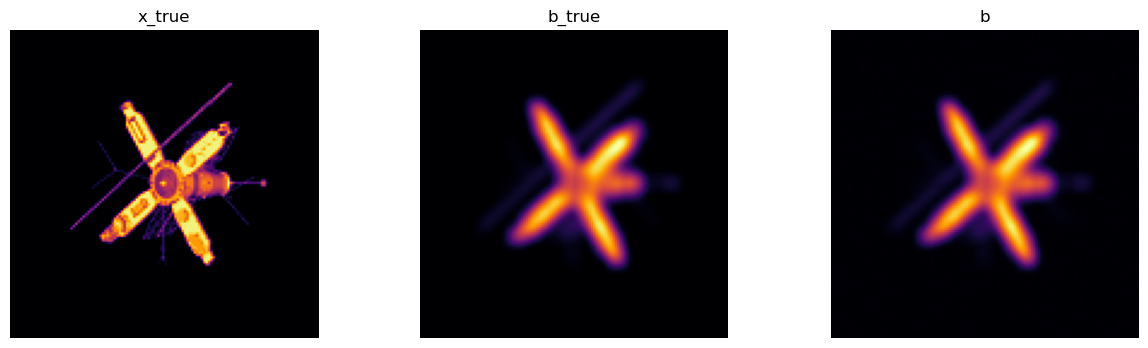

In [4]:
# Display the true desired vs the naive computed solution and vs the approximate regularized computed solution 
plt.figure(figsize=(15,4))
plt.set_cmap('inferno')
plt.axis('off')
plt.subplot(1,3,1), plt.title('x_true'), plt.axis('off'), plt.imshow(x_true.reshape((nx,ny)))
plt.subplot(1,3,2), plt.title('b_true'), plt.axis('off'), plt.imshow(b_true.reshape((nx,ny)))
plt.subplot(1,3,3), plt.title('b'), plt.axis('off'), plt.imshow(b.reshape((nx,ny)))


##### Illustrate the ill-posedness of some inverse problem examples and show the need for regularization
<p>In this example we illustrate the following:

Step 3: Solve the regularized problem with GKS and Hybrid_lsqr that solves

$\|\mathbf A{\mathbf x} - {\mathbf b}\|^2_2 + \lambda \|\mathbf L\mathbf x\|_2^2$ with $\mathbf L$ is the discretization of the two-dimensional first derivative operator for GKS and $L = I$ for Hybrid_lsqr, for an computed value of the regularization parameter $\lambda$. 


In [ ]:
b_vec = b.reshape((-1,1))
(x_hybrid_gmres, info_hybrid_gmres) = Hybrid_GMRES(A, b_vec, n_iter = 100, regparam = 'l_curve', x_true = x_true, delta = delta)

In [5]:
b_vec = b.reshape((-1,1))
(x_hybrid_gmres, info_hybrid_gmres) = Hybrid_GMRES(A, b_vec, n_iter = 100, regparam = 'gcv', x_true = x_true, delta = delta)

running Arnoldi algorithm...: 100%|██████████| 100/100 [00:12<00:00,  7.89it/s]


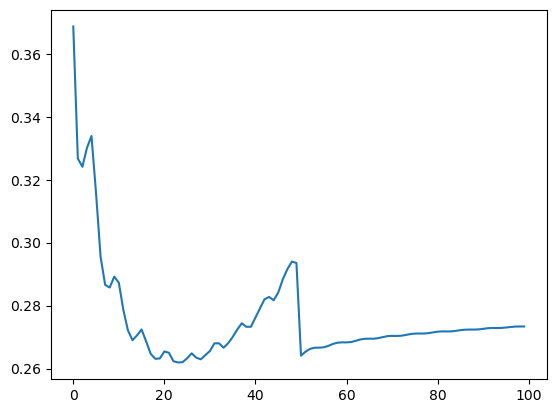

In [6]:
plt.plot(info_hybrid_gmres['relError'])

In [7]:
b_vec = b.reshape((-1,1))
(x_hybrid_lsqr, info_hybrid_lsqr) = Hybrid_LSQR(A, b_vec, n_iter = 100, regparam = 'gcv', x_true = x_true, delta = delta)

running Golub-Kahan bidiagonalization algorithm...: 100%|██████████| 100/100 [00:17<00:00,  5.58it/s]


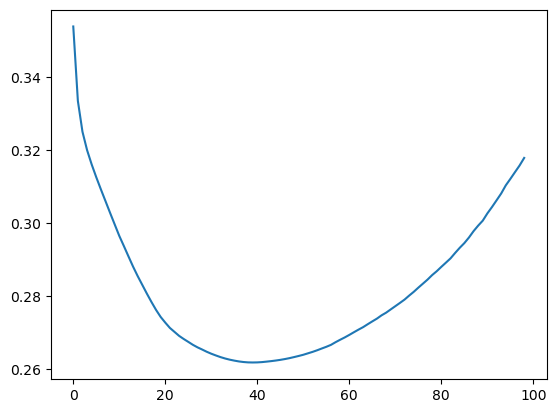

In [8]:
plt.plot(info_hybrid_lsqr['relError'])

(-0.5, 127.5, 127.5, -0.5)

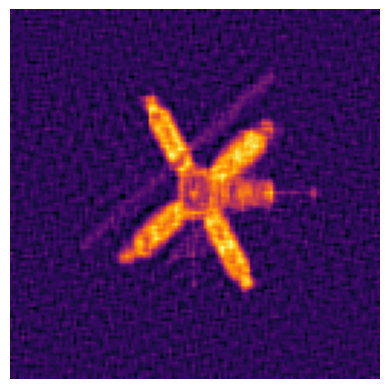

In [9]:
plt.imshow(x_hybrid_lsqr.reshape((nx, ny)))
plt.set_cmap('inferno')
plt.axis('off')

In [10]:
# Compute a solution by GKS
# Define a derivative operator as a regularization operator
L = first_derivative_operator_2d(nx, ny)
data_vec = b.reshape((-1,1))
# Use GKS to compute an approximate solution
(x_gks, info_gks) = GKS(A, data_vec, L, projection_dim=3, n_iter = 100, regparam = 'gcv', x_true = x_true.reshape(-1,1), delta = delta)

running GKS...: 100%|██████████| 100/100 [00:27<00:00,  3.59it/s]


In [11]:
# Compute a solution by GKS
# Define a derivative operator as a regularization operator
L = first_derivative_operator_2d(nx, ny)
data_vec = b.reshape((-1,1))
# Use GKS to compute an approximate solution
(x_gks_L, info_gks_L) = GKS(A, data_vec, L, projection_dim=3, n_iter = 100, regparam = 'gcv', x_true = x_true.reshape(-1,1), delta = delta)

running GKS...: 100%|██████████| 100/100 [00:28<00:00,  3.49it/s]


In [12]:
# Compute a solution by GKS
# Define a derivative operator as a regularization operator
L = first_derivative_operator_2d(nx, ny)
data_vec = b.reshape((-1,1))
# Use GKS to compute an approximate solution
(x_gks, info_gks) = GKS(A, data_vec, L, projection_dim=3, n_iter = 100, regparam = 'gcv', x_true = x_true.reshape(-1,1), delta = delta)

running GKS...: 100%|██████████| 100/100 [00:28<00:00,  3.54it/s]


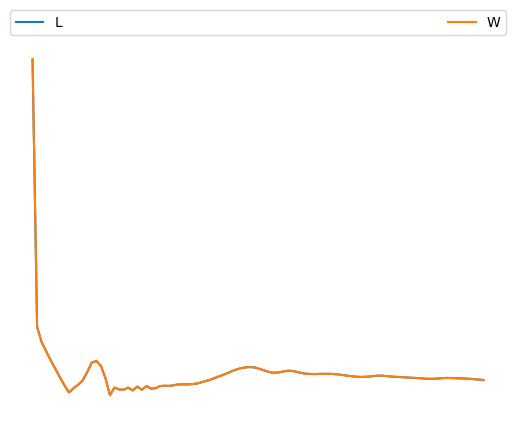

In [14]:
plt.plot(info_gks_L['relError'], label = 'L')
plt.plot(info_gks['relError'], label = 'W')
plt.legend(bbox_to_anchor=(0., 1.02, 1., .102), loc=3,
           ncol=2, mode="expand", borderaxespad=0.)
plt.axis('off')
plt.show()

Solve the regularized problem

$\|\mathbf A{\mathbf x} - {\mathbf b}\|_2 + \lambda \|\mathbf L\mathbf x\|_q$ with $\mathbf L$ is the discretization of the two-dimensional first derivative operator, for an optimal value of $\lambda$. The value of $q$ can be choosen from (0, 2].

In [15]:
# Compute a solution by MMGKS
# Define a derivative operator as a regularization operator
W = create_framelet_operator(nx, ny,2)
data_vec = b.reshape((-1,1))
# Use GKS to compute an approximate solution
(x_mmgks_W, info_mmgks_W) = MMGKS(A, data_vec, W, pnorm=2, qnorm=1, projection_dim=3, n_iter = 100, regparam = 'gcv', x_true = x_true.reshape(-1,1), delta = delta)

running MMGKS...: 100%|██████████| 100/100 [04:16<00:00,  2.57s/it]


In [16]:
# Compute a solution by GKS
# Define a derivative operator as a regularization operator
L = first_derivative_operator_2d(nx, ny)
data_vec = b.reshape((-1,1))
# Use GKS to compute an approximate solution
(x_mmgks_L, info_mmgks_L) = MMGKS(A, data_vec, L, pnorm=2, qnorm=1, projection_dim=3, n_iter = 100, regparam = 'gcv', x_true = x_true.reshape(-1,1), delta = delta)

running MMGKS...: 100%|██████████| 100/100 [00:38<00:00,  2.60it/s]


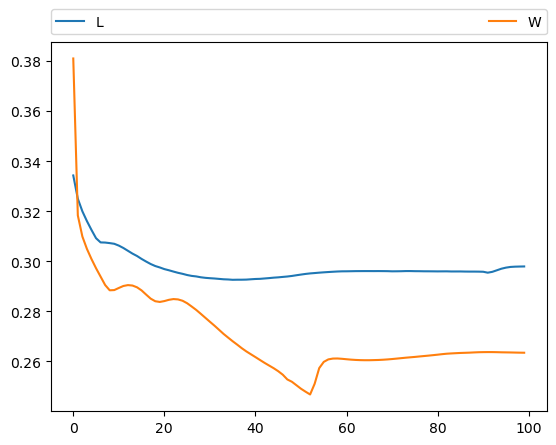

In [17]:
plt.plot(info_mmgks_W['relError'], label = 'L')
plt.plot(info_mmgks_L['relError'], label = 'W')
plt.legend(bbox_to_anchor=(0., 1.02, 1., .102), loc=3,
           ncol=2, mode="expand", borderaxespad=0.)
# plt.axis('off')
plt.show()

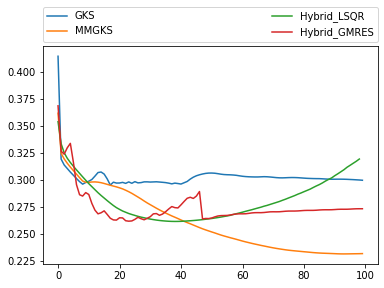

In [ ]:
plot_gks = plt.plot(info_gks['relError'], label='GKS')
plot_mmgks = plt.plot(info_mmgks['relError'], label='MMGKS')
plot_hybrid_lsqr = plt.plot(info_hybrid_lsqr['relError'], label='Hybrid_LSQR')
plot_hybrid_gmres = plt.plot(info_hybrid_gmres['relError'], label = 'Hybrid_GMRES')
plt.legend(bbox_to_anchor=(0., 1.02, 1., .102), loc=3,
           ncol=2, mode="expand", borderaxespad=0.)
plt.show()

(-0.5, 127.5, 127.5, -0.5)

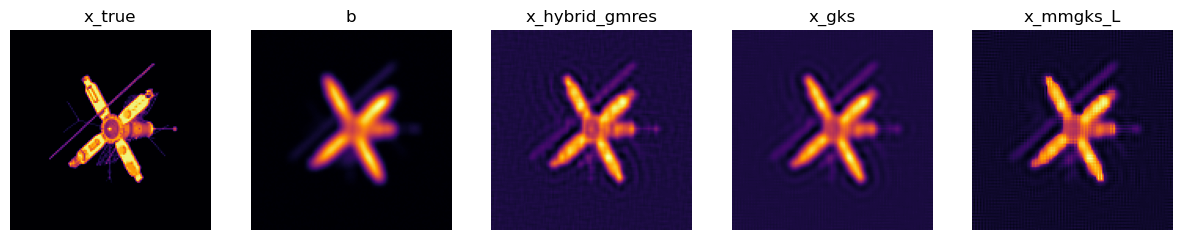

In [20]:
# Display the true desired vs the naive computed solution and vs the approximate regularized computed solution 
plt.figure(figsize=(15,4))
plt.subplot(1,5,1), plt.title('x_true'), plt.axis('off'), plt.imshow(x_true.reshape((nx,ny)))
plt.subplot(1,5,2), plt.title('b'), plt.axis('off'), plt.imshow(b.reshape((nx,ny)))
plt.subplot(1,5,3), plt.title('x_hybrid_gmres'), plt.axis('off'), plt.imshow(x_hybrid_gmres.reshape((nx,ny)))
plt.subplot(1,5,4), plt.title('x_gks'), plt.axis('off'), plt.imshow(x_gks.reshape((nx,ny)))
plt.subplot(1,5,5), plt.title('x_mmgks_L'), plt.axis('off'), plt.imshow(x_mmgks_L.reshape((nx,ny)))
plt.set_cmap('inferno')
plt.axis('off')